In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import ExponentialLR
sns.set_theme()
torch.set_default_dtype(torch.float32) #without it we have underflow and we can encounter problems

In [2]:
def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (torch.tensor(x_train,dtype=torch.float32), torch.tensor(y_train,dtype=torch.float32)), (torch.tensor(x_test,dtype=torch.float32), torch.tensor(y_test,dtype=torch.float32))

In [3]:
class Encoder(nn.Module):
    def __init__(self,sizes) -> None:
        super().__init__()
        self.latent_size=sizes[-1]
        self.network=[]
        for i in range(len(sizes)-2):
            self.network.append(nn.Linear(sizes[i],sizes[i+1]))
            self.network.append(nn.ReLU())
        #self.network.append(nn.Linear(sizes[-2],2*self.latent_size))
        self.encode_mu=nn.Linear(sizes[-2],sizes[-1])
        self.encode_sigma=nn.Linear(sizes[-2],sizes[-1])
        self.network=nn.Sequential(*self.network)

    def forward(self,x):
        x=self.network(x)
        mu=self.encode_mu(x)
        sigma=torch.exp(self.encode_sigma(x))
        return mu,sigma

    #def log_like()


class Decoder(nn.Module):
    def __init__(self,sizes) -> None:
        super().__init__()
        self.network=[]
        for i in range(len(sizes)-2):
            self.network.append(nn.Linear(sizes[i],sizes[i+1]))
            self.network.append(nn.ReLU())
        self.network.append(nn.Linear(sizes[-2],sizes[-1]))
        self.network=nn.Sequential(*self.network)

    def forward(self,x):
        return torch.sigmoid(self.network(x))

class VAE_torch(nn.Module):
    def __init__(self,encoder, decoder,latent_size) -> None:
        super().__init__()
        self.latent_size=latent_size
        self.encoder=encoder
        self.decoder=decoder
    
    def forward(self,x,epsilon=0.0):
        mu,sigma=self.encoder(x)
        eps=torch.normal(0,1,(mu.shape[0],self.latent_size))
        sampled_vector=mu+eps*sigma
        return self.decoder(sampled_vector),mu,sigma

    def sample(self,x,epsilon=0.0):
        mu,sigma=self.encoder(x)
        sampled_vector=torch.zeros(x.shape[0],self.latent_size)
        for j in range(mu.shape[0]):
            sampled_vector[j,:]=torch.distributions.Normal(mu[j],sigma[j]).sample()
        print(sampled_vector)
        return self.decoder(sampled_vector)


def KL(mean,sigma,epsilon=0):
    #print (torch.mean((torch.sum(sigma.pow(2),dim=1)+torch.sum(mean.pow(2),dim=1)-torch.sum(torch.log(sigma**2+epsilon),dim=1)-1)))
    return 0.5*torch.sum((torch.sum(sigma.pow(2),dim=1)+torch.sum(mean.pow(2),dim=1)-torch.sum(torch.log(sigma**2+epsilon),dim=1)-1))

def ELBO(values,pred_values,mean,sigma,beta=1):
    #return torch.mean(torch.mean((values-pred_values)**2,dim=1)+KL(mean,sigma))
    #print(nn.functional.binary_cross_entropy(pred_values, values,reduction="sum"))
    return (nn.functional.binary_cross_entropy(pred_values, values,reduction="sum")+beta*KL(mean,sigma))/values.shape[0]

def visualize(res1,VAE):
    new=VAE.sample(res1.expand(5,784))
    f,axes=plt.subplots(2,3,figsize=(21,14))
    ax=axes.flatten()[0]
    ax.imshow(res1.reshape(28,28),cmap="viridis_r")
    ax.set_title("Original image")
    for spine in ax.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(4)
    for j in range(5):
        ax=axes.flatten()[j+1]
        ax.imshow(new[j,:].detach().numpy().reshape(28,28),cmap="viridis_r")
    plt.tight_layout()

In [4]:
(xtrain,ytrain),(xtest,ytest)=load_mnist()

In [5]:
num_epoch=30    
batch=100
VAE=VAE_torch(Encoder([784,110,30,10]),Decoder([10,30,110,784]),10)
optim=torch.optim.Adam(VAE.parameters(),lr=0.003)
scheduler = ExponentialLR(optim, gamma=0.95)
beta=1
err_train=[]
err_test=[]
for i in range(num_epoch):
    for j in range(0,60000,batch):
        xbatch=xtrain[j:j+batch]
        optim.zero_grad()
        results,mean,sigma=VAE(xbatch)
        loss=ELBO(xbatch,results,mean,sigma,beta=beta)
        loss.backward()
        optim.step()
    with torch.no_grad():
        test_res,mean,sigma=VAE(xtest)
        loss_test=ELBO(xtest,test_res,mean,sigma,beta=beta)
        print("Epoche: ",i,"loss train: {:.3f}".format(loss.item()),"loss test: {:.3f}".format(loss_test.item()))
        err_train.append(loss.item())
        err_test.append(loss_test.item())
    if (i>200):
        scheduler.step()
        print("new step: {:.5f}".format(scheduler.get_last_lr()[0]))

Epoche:  0 loss train: 179.336 loss test: 164.070
Epoche:  1 loss train: 149.704 loss test: 147.996
Epoche:  2 loss train: 143.248 loss test: 144.813
Epoche:  3 loss train: 141.403 loss test: 143.155
Epoche:  4 loss train: 136.293 loss test: 139.639
Epoche:  5 loss train: 134.241 loss test: 138.174
Epoche:  6 loss train: 133.826 loss test: 137.133
Epoche:  7 loss train: 132.460 loss test: 137.995
Epoche:  8 loss train: 131.784 loss test: 136.736
Epoche:  9 loss train: 131.707 loss test: 135.802
Epoche:  10 loss train: 132.484 loss test: 135.466
Epoche:  11 loss train: 130.943 loss test: 135.341
Epoche:  12 loss train: 131.493 loss test: 135.737
Epoche:  13 loss train: 129.534 loss test: 132.079
Epoche:  14 loss train: 130.373 loss test: 134.644
Epoche:  15 loss train: 129.079 loss test: 132.501
Epoche:  16 loss train: 129.605 loss test: 133.778
Epoche:  17 loss train: 129.224 loss test: 131.721
Epoche:  18 loss train: 128.863 loss test: 131.952
Epoche:  19 loss train: 128.602 loss test

Text(0.5, 0, 'epoche number')

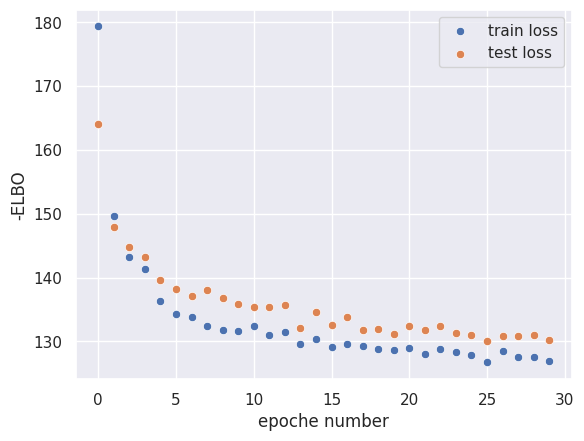

In [6]:
sns.scatterplot(x=np.arange(0,len(err_train)),y=err_train,label="train loss")
sns.scatterplot(x=np.arange(0,len(err_test)),y=err_test,label="test loss")
plt.ylabel(r"-ELBO")
plt.xlabel("epoche number")

tensor([[ 1.0136, -1.6156,  1.1440, -0.3476,  0.6118, -0.1613, -1.8140,  1.5490,
         -0.1734, -0.9137],
        [ 0.8592, -0.0318, -1.7685, -0.2874,  0.5823,  0.1827, -1.4863,  1.7047,
          0.0213,  1.4113],
        [ 1.2918,  1.4934, -0.0495, -0.4154,  0.1422, -0.3573, -1.8731,  1.5163,
         -0.1059,  2.2252],
        [ 1.1458,  0.1555,  0.0567, -0.5370,  1.9526, -0.8178, -1.9129,  1.4684,
          0.1632, -1.0212],
        [ 1.2764, -0.7374,  0.9120, -0.4131, -0.2190, -0.1389, -1.5831,  1.6944,
         -0.0770, -0.7339]])


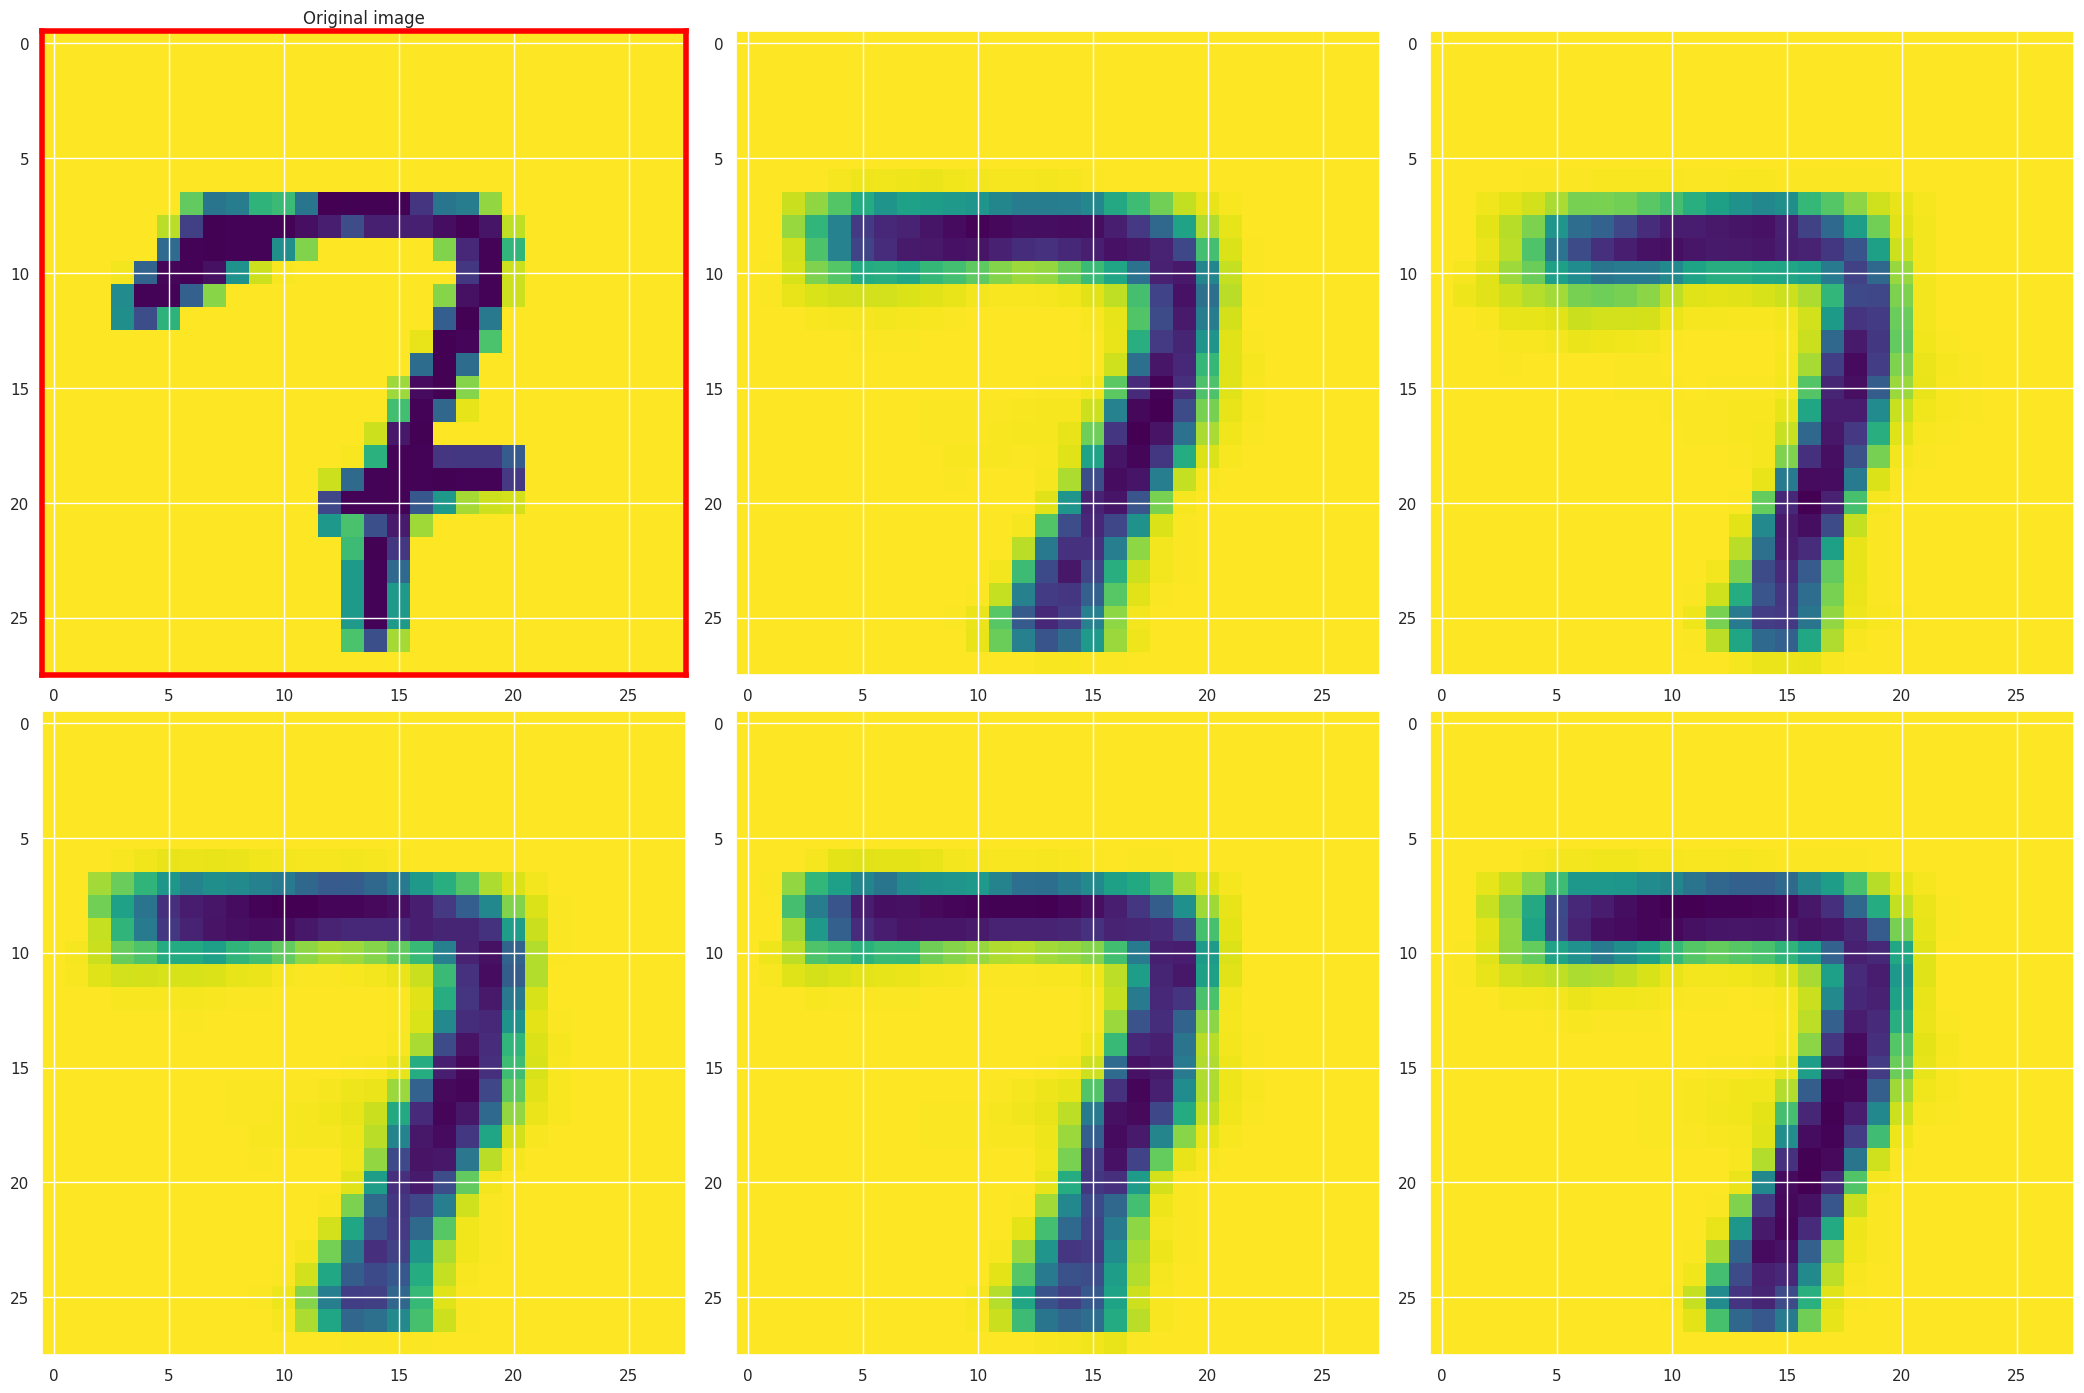

In [7]:
n=36
visualize(xtest[n],VAE)